In [1]:
import os
# os.environ['CUDA_VISIBLE_DEVICES']='0'
import time
from helper.model import *
from helper.data import *
# import cv2


import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))


ModuleNotFoundError: No module named 'keras.backend.tensorflow_backend'; 'keras.backend' is not a package

In [2]:
import os

# 檢查當前工作目錄
print("Current working directory:", os.getcwd())
print("Files in testset:", os.listdir('./'))

dataset = 'dataset_Mitochondrion/'

# 列出 testset 資料夾中的文件
print("Files in testset:", os.listdir(dataset))

print("Files in testset:", os.listdir(dataset+'train_image'))
n_timage = len(os.listdir(dataset+'train_image'))
print(n_timage)
n_vimage = len(os.listdir(dataset+'val_image'))
print(n_vimage)

Current working directory: /home/cyjui/wjlee_dev/240513-unet
Files in testset: ['UNET.ipynb', 'U-net.ipynb', 'dataset_Mitochondrion', 'UNET.zip', '.ipynb_checkpoints', 'UNet_Membrane.hdf5', 'helper']
Files in testset: ['val_image', 'train_label', 'train_image', 'val_label']
Files in testset: ['0368.png', '0048.png', '0032.png', '0400.png', '0160.png', '0256.png', '0144.png', '0240.png', '0320.png', '0464.png', '0448.png', '0352.png', '0176.png', '0128.png', '0192.png', '0432.png', '0336.png', '0384.png', '0112.png', '0096.png', '0000.png', '0304.png', '0016.png', '0288.png', '0208.png', '0416.png', '0080.png', '0064.png', '0272.png', '0224.png']
30
30


### ============================================================================================================
    在使用 Keras 進行深度學環的訓練時，steps_per_epoch 參數指的是在每一個 epoch 中，需要進行多少次梯度更新，或者說進行多少批次(batch)的訓練。這個參數的設定通常取決於訓練資料集的大小以及你選擇的批次大小(batch size)。舉例來說，如果你有 2000 個訓練樣本，並且你設定每個批次包含 2 個樣本，那麼理論上你的 steps_per_epoch 應該設定為 1000，因為 2000 / 2 = 1000。這樣在每個 epoch 中，你的模型會看過全部的 2000 個樣本一次。這個參數的正確設定可以幫助確保模型在每個 epoch 結束時都能有效學習到整個訓練集的資訊。如果使用了資料生成器，則 steps_per_epoch 的設定尤為重要，因為生成器可以不斷產生數據，所以需要明確告訴模型每個 epoch 需要從生成器中取出多少次數據。

@ batch_size 決定了每次生成數據的數量。 (每次批次(batch)訓練所輸入的圖像數量)

@ 
steps_per_epoch 決定了每個 epoch 中進行多少次權重更新（即執行多少個批次）。


In [19]:
%%time

from tensorflow.keras.optimizers import Adam
import math
tic = time.time()

BatchSize = 3    # batch_size 為 1 的訓練方法有時被稱為 隨機梯度下降
steps_per_epoch = math.ceil(n_timage/BatchSize)  
validation_steps = math.ceil(n_vimage/BatchSize)  

#沒有明確 steps_per_epoch 與 validation_steps 可能導致每次 epoch 結束時驗證階段只處理一部分數據，從而影響對模型性能的準確評估。
#因此，恰當地設定這個參數對於獲得可靠的模型評估和性能反饋非常重要。

data_gen_args = dict(
#     rescale=1./255,
                     rotation_range=360,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')

train_set = trainGenerator(BatchSize, dataset,'train_image','train_label', data_gen_args,save_to_dir = None)
# val_set = testGenerator('dataset/val_image',30 , target_size = (512,512))
# val_data_gen_args = dict(rescale=1./255)
# val_set = trainGenerator(BatchSize,'dataset_s','val_image','val_label',val_data_gen_args,save_to_dir = None)

# val_set = ImageDataGenerator().flow_from_directory(
#                     dataset,
#                     classes=['val_image'],
#                     class_mode=None,
#                     color_mode="grayscale",
#                     target_size=(512, 512),
#                     batch_size=1,
#                     seed=1)

data_gen_args = dict()
val_set = trainGenerator(BatchSize, dataset,'train_image','train_label', data_gen_args, save_to_dir = None)

model = unet()
# model = simple_unet_model()


# solver = Adam(learning_rate=1e-4)
solver = Adam(lr=1e-5)
model.compile(optimizer=solver, 
              loss='binary_crossentropy', metrics=['accuracy'])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint('UNet_Membrane.hdf5', monitor='loss',verbose=1, save_best_only=True)

history = model.fit_generator(train_set, 
                              steps_per_epoch=200,
                              epochs=10,
                    callbacks=[model_checkpoint], validation_data=val_set, 
                    validation_steps = validation_steps)

toc = time.time()
print("Time=" + str((toc-tic)) + "sec")

Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.
Epoch 1/10
199/200 [============================>.] - ETA: 0s - loss: 0.2199 - acc: 0.9822Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.
10/10 [==============================] - 1s 122ms/step - loss: 0.2166 - acc: 0.9841

Epoch 00001: loss improved from inf to 0.22005, saving model to UNet_Membrane.hdf5
200/200 [==============================] - 47s 237ms/step - loss: 0.2200 - acc: 0.9822 - val_loss: 0.2166 - val_acc: 0.9841
Epoch 2/10
10/10 [==============================] - 1s 78ms/step - loss: 0.2171 - acc: 0.9841

Epoch 00002: loss did not improve from 0.22005
200/200 [==============================] - 45s 227ms/step - loss: 0.2237 - acc: 0.9819 - val_loss: 0.2171 - val_acc: 0.9841
Epoch 3/10
10/10 [==============================] - 1s 78ms/step - loss: 0.2317 - acc: 0.9831

Epoch 00003: loss did not improve from 0.22005
200/200 [==============================] - 45s 227

In [6]:
# model.summary()

In [11]:
# # 繪製訓練 & 驗證的準確率值
import matplotlib.pyplot as plt
%matplotlib inline

# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Model Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

# # 繪製訓練 & 驗證的損失值
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')

In [12]:
!ls dataset_Mitochondrion/train_label

# BASE_PATH = "dataset_Mitochondrion/train_label/"

# lbls = os.listdir(BASE_PATH)

# for lbl in lbls:

#     img_path = os.path.join(BASE_PATH, lbl)
#     img = load_img(img_path, target_size=img_size, color_mode='grayscale')
#     img = img_to_array(img)
    
#     print(np.sum(img > 0.0)/len(img.flatten()))


0000.png  0064.png  0128.png  0192.png	0256.png  0320.png  0384.png  0448.png
0016.png  0080.png  0144.png  0208.png	0272.png  0336.png  0400.png  0464.png
0032.png  0096.png  0160.png  0224.png	0288.png  0352.png  0416.png
0048.png  0112.png  0176.png  0240.png	0304.png  0368.png  0432.png


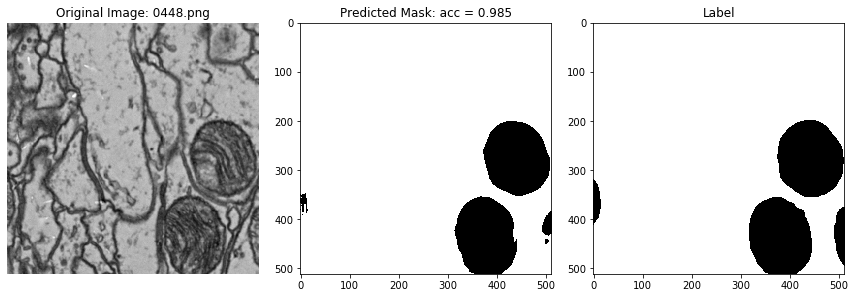

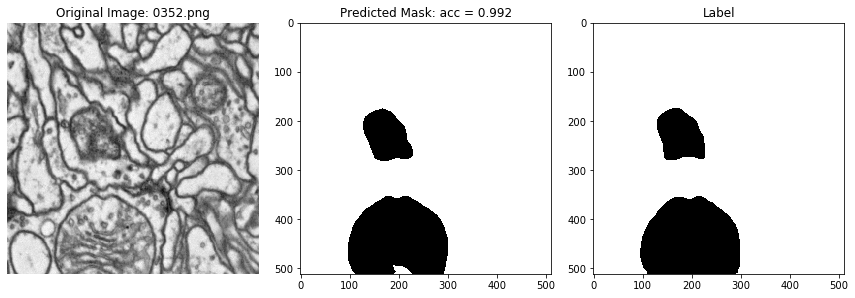

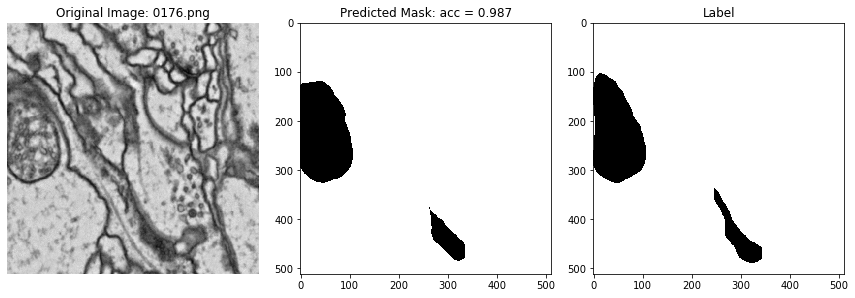

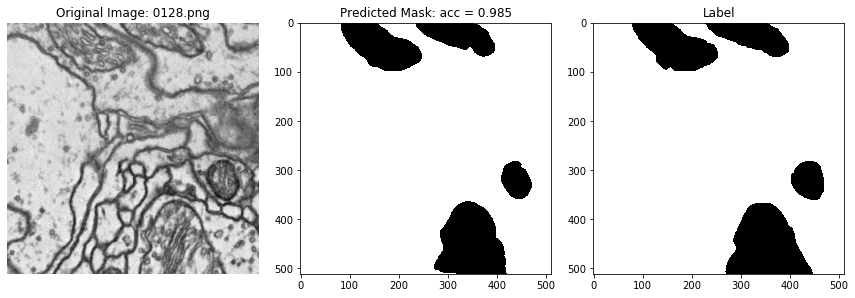

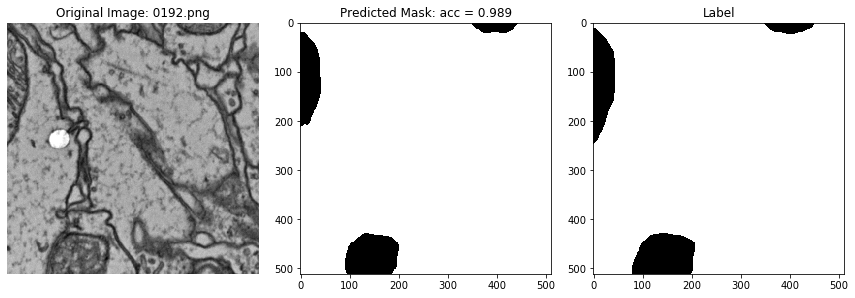

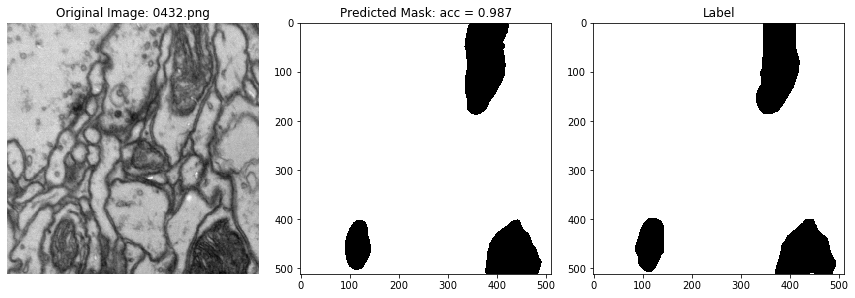

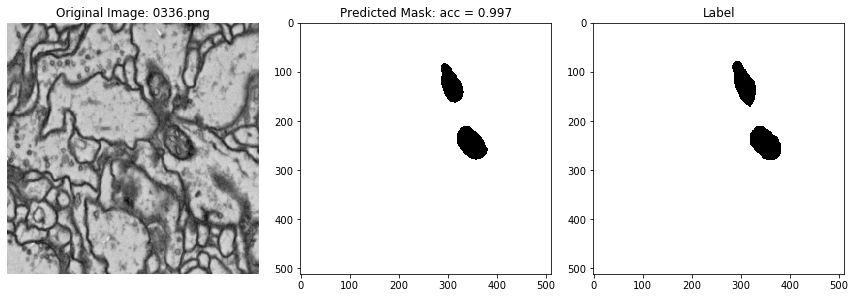

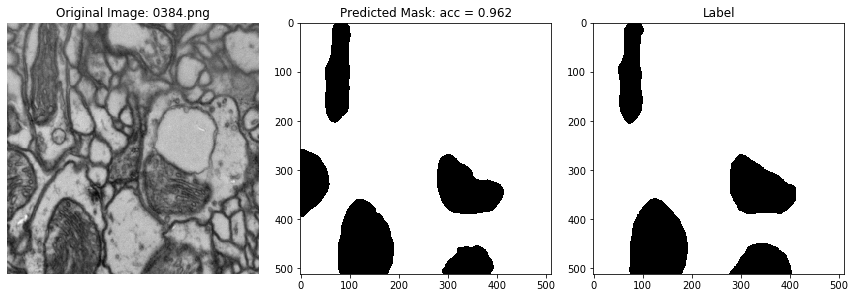

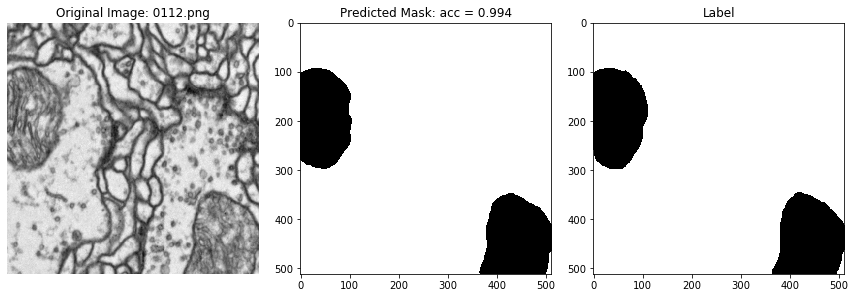

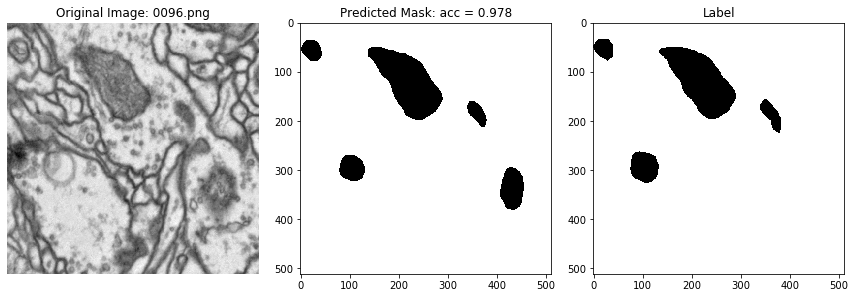

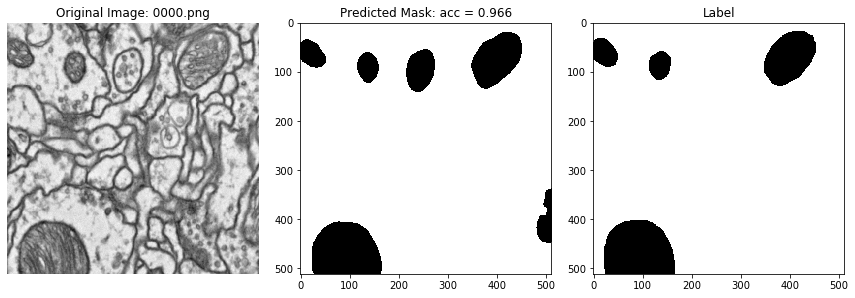

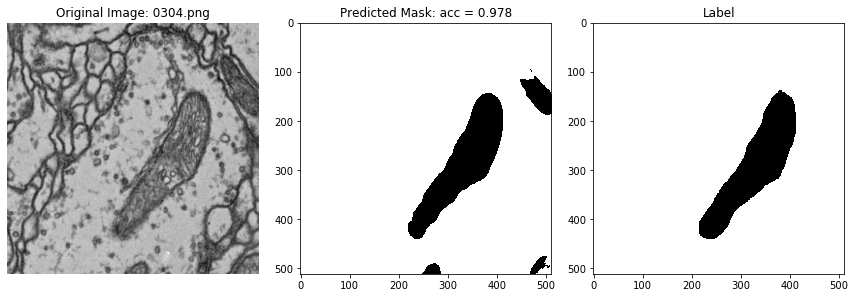

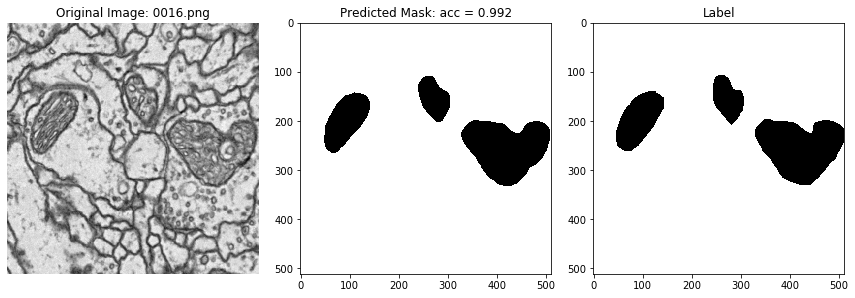

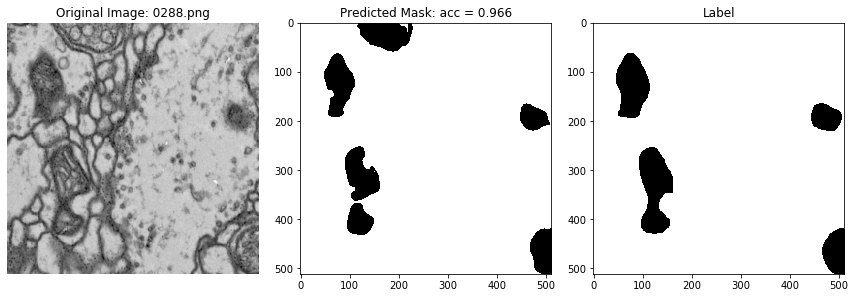

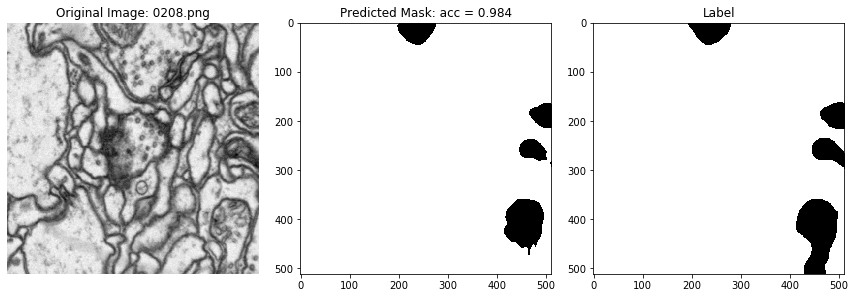

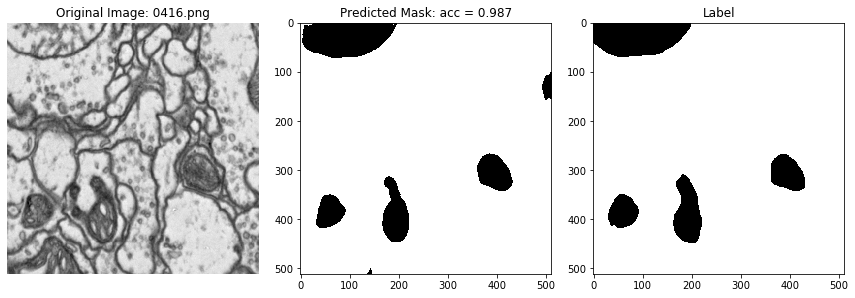

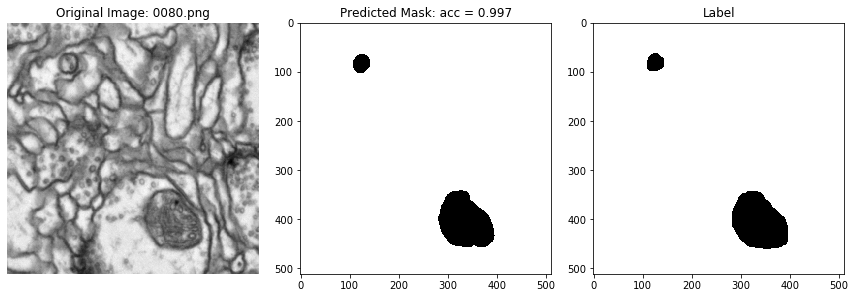

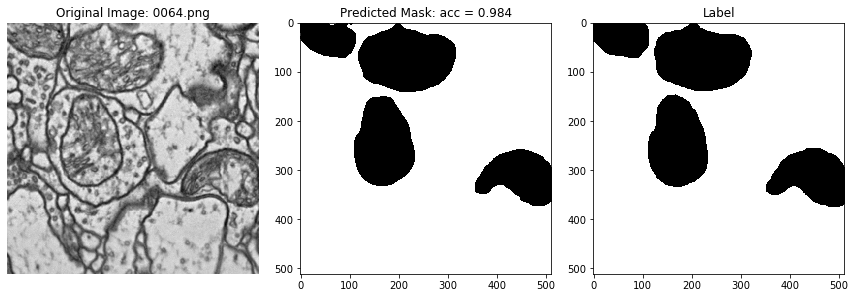

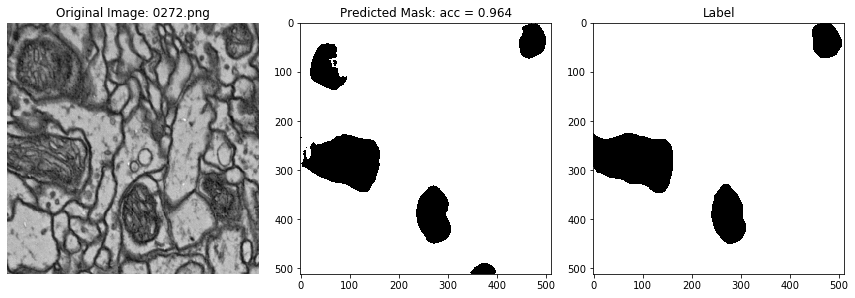

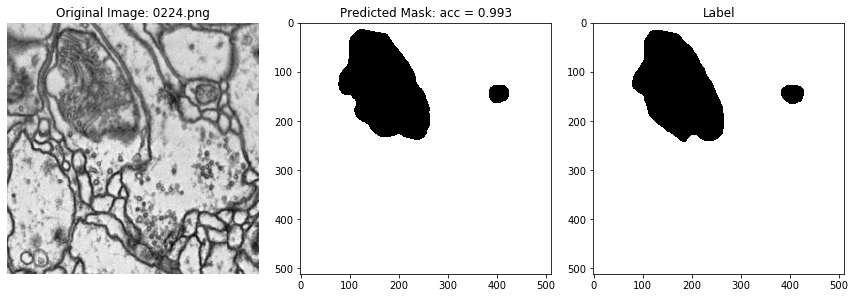

In [31]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
# import cv2
import numpy as np
# 設置圖像尺寸和路徑
img_size = (512, 512)  # 設定成模型訓練時使用的圖像尺寸
test_path = dataset + 'train_image'  # 測試圖像文件夾的路徑

# 獲取測試圖像文件列表
test_images = os.listdir(test_path)

### cyjui 

DST_FOLDER="results-240514"

try:
    os.mkdir(DST_FOLDER)
except:
    pass


# 預處理圖像並預測
for image_name in test_images[10:]:
    img_path = os.path.join(test_path, image_name)
    img = load_img(img_path, target_size=img_size, color_mode='grayscale')  # 確保讀取模式與訓練時相同
    img_array = img_to_array(img)
    img_array = img_array/ 255.0 # 正規化

    img_array = np.expand_dims(img_array, axis=0)  # 增加"批次"維度 : 原圖(512, 512, 1) 加入批次項 => (1, 512, 512, 1) 才能代入model.predict
    
    # 預測結果
    prediction = model.predict(img_array)
    
    predicted_image = (prediction[0, :, :, 0] > 0.5)*255  # 獲取預測圖像

    # 假設 predicted_image 是模型的輸出
    # binary_mask  = cv2.threshold(predicted_image, 0.5, 1, cv2.THRESH_BINARY)[1]  #
    # predicted_image =binary_mask*255
    # print(predicted_image)
   
    # 視覺化原始圖像和預測結果
    plt.figure(figsize=(8+4, 4))
    plt.subplot(1, 3, 1)
    plt.title('Original Image: {:}'.format(image_name))
    plt.imshow(img, cmap='gray')
    
    plt.axis('off')
    
    ### cyjui
    lbl_path = os.path.join('dataset_Mitochondrion/train_label', image_name)
    lbl = load_img(lbl_path, target_size=img_size, color_mode='grayscale')  # 確保讀取模式與訓練時相同
    lbl = img_to_array(lbl)
    acc = (lbl.flatten() == predicted_image.flatten()).sum()/len(lbl.flatten())
    
    plt.subplot(1, 3, 2)
    plt.title('Predicted Mask: acc = {:.3f}'.format(acc))
    plt.imshow(predicted_image, cmap='gray', vmin=0.0, vmax=1.0)
#     plt.axis('off')
    
    plt.subplot(1, 3, 3);
    plt.title('Label')
    plt.imshow(lbl[:, :, 0], cmap='gray', vmin=0.0, vmax=1.0)
#     plt.axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(DST_FOLDER, image_name))
    
    
#     plt.show()
    
    


In [7]:
# val_gen = ImageDataGenerator().flow_from_directory(
#     dataset,
#     classes=['train_image'],
#     class_mode=None,
#     color_mode="grayscale",
#     target_size=(512, 512),
#     batch_size=1,
#     seed=5)

# for img in val_gen:
#     img_processed = img / 255.0
#     pred = model.predict(img_processed)
#     plt.figure(figsize=(8, 4))
#     plt.subplot(1, 2, 1)
#     plt.title('Original Image')
#     plt.imshow(img[0])
#     plt.subplot(1, 2, 2)
#     plt.title('Predicted Mask')
#     plt.imshow(pred[0, :, :, 0], cmap='gray')
#     plt.show()
#     # break  # Show one example
